# IRC belief to neural data 

Using IRC, we infered monkey's belief from their behavior.
We can then fit the neural acitivty to the behavioral inferred belief, to see the benifit of using IRC.


In [51]:
# imports
import sys
import os
os.chdir('/workspaces/ffsb/test/neural')
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))
os.chdir('/workspaces/ffsb')

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import scipy.interpolate as interpolate
import random
from sklearn.metrics import mean_squared_error, r2_score
from plot_ult import *
import configparser
from sklearn import linear_model
from pathlib import Path
from notification import notify
from env_config import Config
from firefly_task import ffacc_real
from monkey_functions import *
from InverseFuncs import *
from stable_baselines3 import TD3
import time
from torch.distributions.multivariate_normal import MultivariateNormal
import heapq
import warnings
import matplotlib.pyplot as plt
import copy
from cmaes import CMA
from numpy.lib.npyio import save
import pandas as pd
import pickle
from scipy.io import loadmat
from scipy.interpolate import interp1d
from datetime import datetime
from copy import deepcopy
from firefly_utils.lfp_class import lfp_class
from firefly_utils.behav_class import *
from firefly_utils.spike_times_class import spike_counts
from firefly_utils.data_handler import data_handler
from matplotlib import pyplot as plt
from numpy import pi
from sklearn.cross_decomposition import CCA
import torch
import numpy as np

from sklearn.model_selection import cross_val_predict, cross_val_score


## Load neural data (.mat file) and behaviral data (from IRC)
the neural data file also has some behaivral data, such as current velocity.
we can use this as a sanity check to making sure things are right.

In [13]:
# load neural data

config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
resdir=config['Datafolder']['data']
resdir = Path(resdir)


dat = loadmat(resdir/'neuraltest/m53s31.mat') # this is a example session with good recording, more neurons
# dat = loadmat(resdir/'neural/m53s36.mat') # this is a pert example


behav_stat_key = 'behv_stats'
spike_key = 'units'
behav_dat_key = 'trials_behv'
lfp_key = 'lfps'

pre_trial_dur = 0.5
post_trial_dur = 0.5
exp_data = data_handler(dat, behav_dat_key, spike_key, lfp_key, 
                        behav_stat_key, pre_trial_dur=pre_trial_dur,             extract_fly_and_monkey_xy=True,
                        post_trial_dur=post_trial_dur,extract_cartesian_eye_and_firefly=True,
                        lfp_beta=None, lfp_alpha=None, extract_lfp_phase=True)
# list(exp_data.behav.continuous.__dict__.keys())
exp_data.set_filters('all', True)
ts = exp_data.rebin_time_stamps(0.1)
t_targ=dict_to_vec(exp_data.behav.events.t_targ)
t_start=t_targ
t_stop = dict_to_vec(exp_data.behav.events.t_stop)
var_names = 'rad_vel','ang_vel','x_monk','y_monk', 'eye_hori', 'eye_vert','x_fly_screen','z_fly_screen','x_eye_screen','z_eye_screen',"x_fly_rel","y_fly_rel","ang_vel"
y,X,trial_idx = exp_data.concatenate_inputs(*var_names,t_start=t_start,t_stop=t_stop, time_stamps=ts)

trials=np.unique(trial_idx)
yes=0
total=0
for itrial in range(len(trials)):
    if len(X['x_fly_rel'][trial_idx==trials[itrial]])<1:
        continue
    d=(X['x_fly_rel'][trial_idx==trials[itrial]][-1]**2 + X['y_fly_rel'][trial_idx==trials[itrial]][-1]**2)**0.5
    if d < 65: yes+=1
    total+=1
print(f'number of trial: {len(trials)}, \nsession success rate is ', yes/total)


unable to extract pairs, different blocks number
no eyetracking...
no normalized t_ptb (t_ptbn)
['all', 'reward', 'density', 'ptb', 'microstim', 'landmark', 'replay', 'controlgain', 'firefly_fullON']
Succesfully set filter
number of trial: 700, 
session success rate is  0.5642857142857143


In [14]:
brainarea=dat['units']['brain_area']


In [15]:
# load behavioral data

with open(resdir/'neuraltest/res/m53s31_0223newformatbelief', 'rb') as f:
    res = pickle.load(f)

y_ = res['y']
X = {k: res[k] for k in ['rad_vel', 'ang_vel', 'x_monk', 'y_monk']}
trial_idx = res['trial_idx']
beliefs = res['belief']
covs = res['covs']
s = np.vstack([v for v in X.values()])
s = s.T


In [16]:
# use b-spline to process neural data

kernel_len = 7  # should be about +- 325ms
knots = np.hstack(([-1.001]*3, np.linspace(-1.001, 1.001, 5), [1.001]*3))
tp = np.linspace(-1., 1., kernel_len)
bX = splineDesign(knots, tp, ord=4, der=0, outer_ok=False)

# with initiate_plot(3, 2, 200) as f:
#     ax = f.add_subplot(111)
#     plt.plot(bX)
#     plt.title('B-spline kernel')
#     quickspine(ax)
#     plt.xticks([0, kernel_len-1])
#     ax.set_xticklabels([-kernel_len*50, kernel_len*50])
#     plt.xlabel('time, ms')
#     plt.ylabel('coef')


with suppress():
    modelX = convolve_loop(y_.T, trial_idx, bX)  # ts, neurons
pos_xy = np.hstack((X['x_monk'].reshape(-1, 1),
                   X['y_monk'].reshape(-1, 1)))  # ts, xy
# remove bad data
non_nan = ~np.isnan(pos_xy.sum(axis=1))
modelX = modelX[non_nan]
pos_xy = pos_xy[non_nan]
belief_xy = beliefs[:, [0, 1]][non_nan]

In [17]:
# calculate relative beliefs and states

states_rel, belief_rel = [], []
for itrial in range(len(trials)):
    xr, yr = world2mk(X['x_monk'][trial_idx == trials[itrial]], X['y_monk'][trial_idx == trials[itrial]], X['ang_vel'][trial_idx ==
                      trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    states_rel.append(np.vstack([xr, yr]))

    xr, yr = world2mk(beliefs[trial_idx == trials[itrial]][:, 0], beliefs[trial_idx == trials[itrial]][:, 1], X['ang_vel']
                      [trial_idx == trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    belief_rel.append(np.vstack([xr, yr]))

states_rel = np.hstack(states_rel).T
belief_rel = np.hstack(belief_rel).T

# Fitting the belief uncertainty

in this model, we use self centric (rotated according to heading direction) covariance matrix ((2,2) for position x,y) as the summary statistics for uncertainty.
if brain encodes uncertainty in a similar way, we should be able to see that in neurons.


## Fitting belief uncertainty to raw summary stats

we found that the uncertainty for y is better correlated with neural activity. 
x uncertainty shows a non linear curve, which is also in y direction but very weak.

the uncertainty direction (xy) has very weak correlation to neural activities.

linear regression score 0.5653859329098844


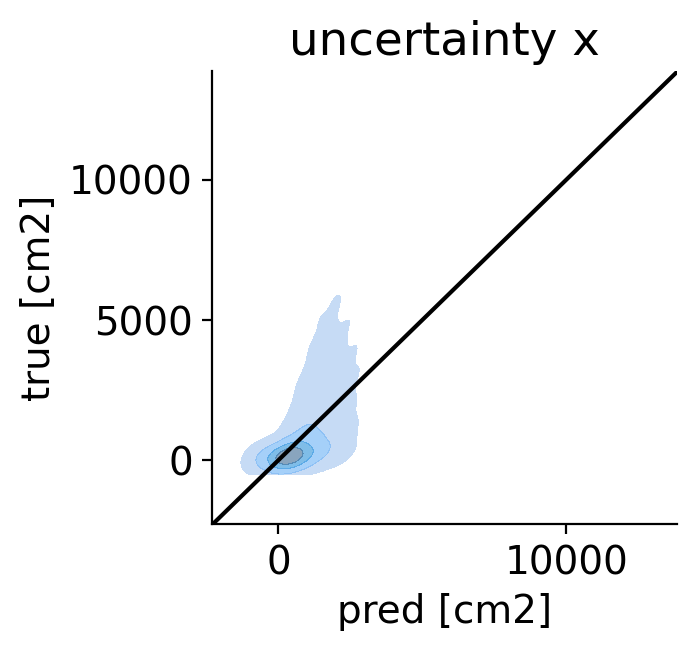

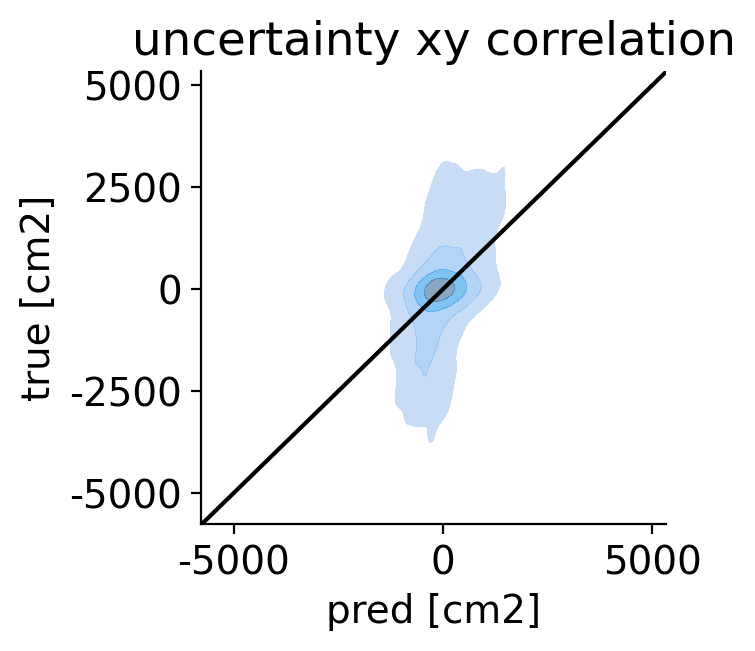

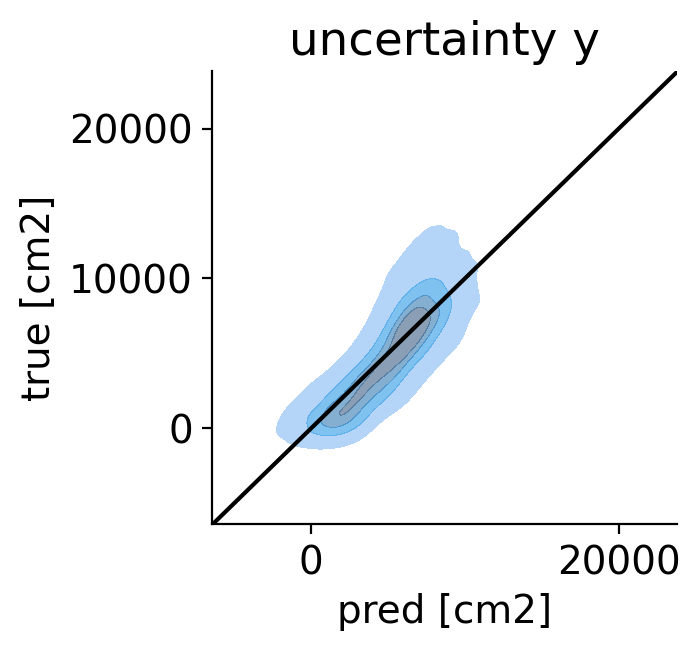

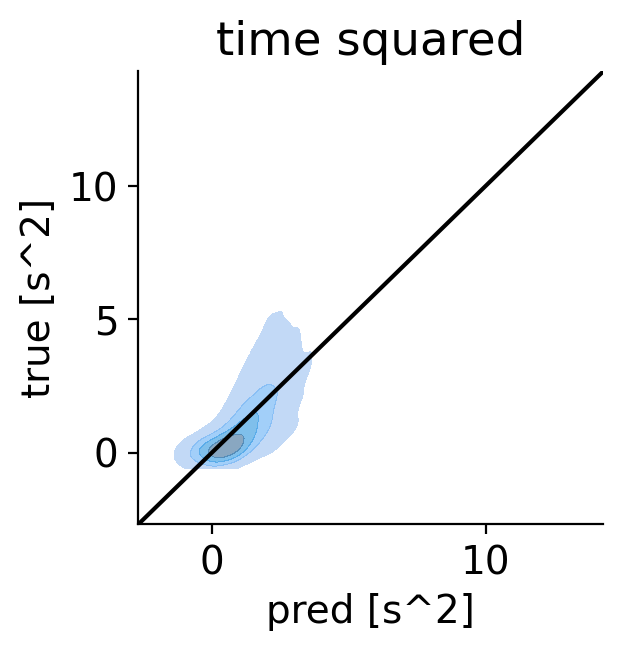

In [19]:
# r --> uncertainty summary statistics in each trial and time

trialtime=[]
fulltime=np.arange(0,7,0.1)
for itrial in range(len(trials)):
    thistime=len(X['x_monk'][trial_idx==trials[itrial]])
    trialtime.append(fulltime[:thistime])
trialtime=np.hstack(trialtime).T
len(trialtime)

uncertainty=[c[:2,:2].flatten()[[0,1,3]] for c in covs]
uncertainty=np.array(uncertainty)
together=np.hstack([uncertainty,trialtime.reshape(-1,1)**2,])
trainx, trainy, testx, testy,mask=splitdataxy(np.power(modelX,2), together)

linreg = linear_model.LinearRegression()
linreg.fit(trainx, trainy)
print('linear regression score',linreg.score(testx, testy))
pred  = linreg.predict(testx)
plot_pred(pred[:,0],testy[:,0], title='uncertainty x', unit='cm2',every=1)
plot_pred(pred[:,1],testy[:,1], title='uncertainty xy correlation', unit='cm2',every=1)
plot_pred(pred[:,2],testy[:,2], title='uncertainty y', unit='cm2',every=1)
plot_pred(pred[:,3],testy[:,3], title='time squared', unit='s^2',every=1)


## Fit to belief summary stats (rotated to egocentric)

as we saw earlier, brain likely encodes the position in self centeric coord instead of world centric. 
this might also apply to unceratinty as well.
we can rotate the uncertainty according to the heading direction.
such that the uncertainty has forward lateral direction instead of x and y.
we also hypothesized that by doing the rotation, the uncertainty xy fitting will be reduced.

we found that uncertainty in lateral direction fit better to neural activity than uncertainty in x direction.
also, we saw it seems uncertainty seems to be a quadratic feature.
the reduce in co uncerainty is not very clear, since the co uncertainty in xy is already very low.

In [25]:
# calculate the relative cov (rotate ccw 180+heading from mid degree)

belief_heading = beliefs[:,2][non_nan]
rotdegree=belief_heading+180
relativeposcov=[]
for degree, thiscov in zip(rotdegree, covs):
    R=np.array([[np.cos(-degree/180*pi),-np.sin(-degree/180*pi)],[np.sin(-degree/180*pi),np.cos(-degree/180*pi)]])
    relativeposcov.append(R.T@thiscov[:2,:2]@R)
relativeposcov=np.stack(relativeposcov)
relativeposcov.shape


(11331, 2, 2)

use neural activty squred to predict uncertainty var

linear regression score 0.3828344568097655


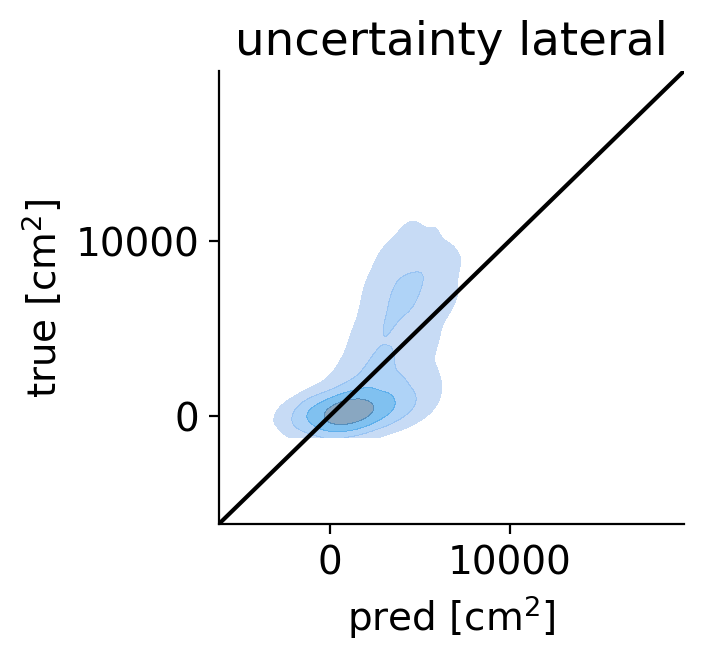

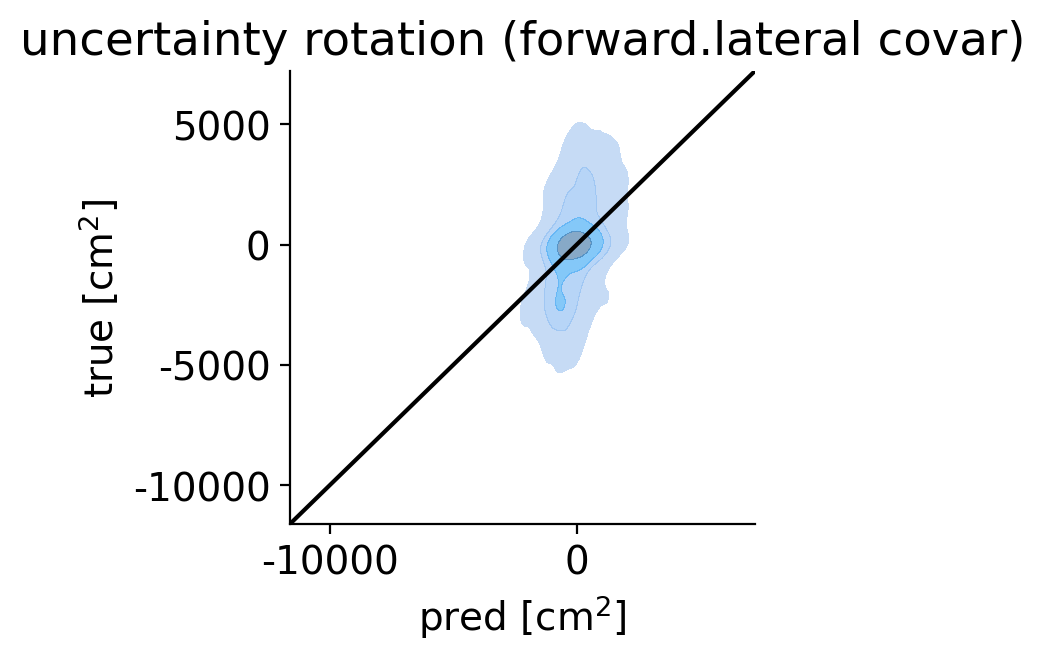

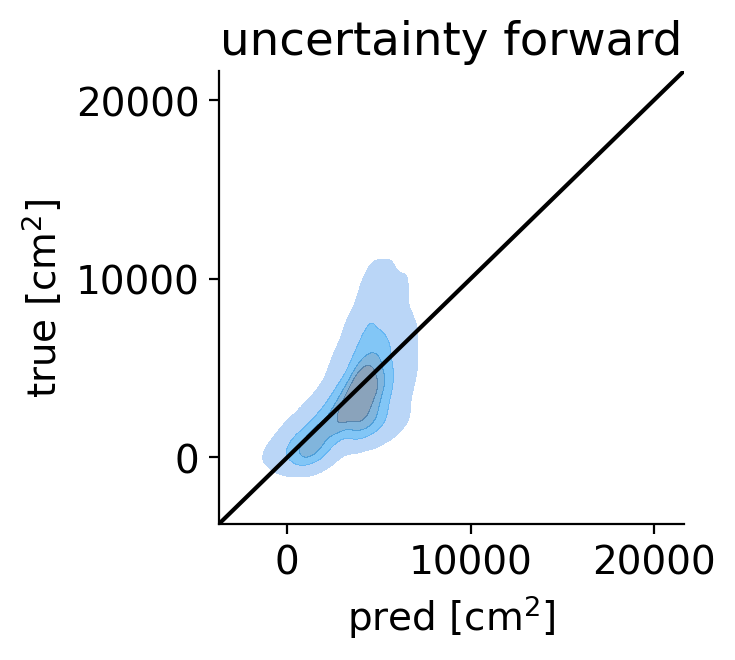

In [31]:
# r --> uncertainty summary statistics in each trial, egocentric
uncertainty=[c[:2,:2].flatten()[[0,1,3]] for c in relativeposcov]
uncertainty=np.array(uncertainty)
trainx, trainy, testx, testy,mask=splitdataxy(np.power(modelX,2), uncertainty)

linreg = linear_model.LinearRegression()
linreg.fit(trainx, trainy)
print('linear regression score',linreg.score(testx, testy))
pred  = linreg.predict(testx)
plot_pred(pred[:,0],testy[:,0], title='uncertainty lateral', unit=r'$cm^2$',every=1)
# plt.scatter(pred[:,0],testy[:,0], s=1, alpha=0.5)
# plt.show()
plot_pred(pred[:,1],testy[:,1], title='uncertainty rotation (forward.lateral covar)', unit=r'$cm^2$',every=1)
plot_pred(pred[:,2],testy[:,2], title='uncertainty forward', unit=r'$cm^2$',every=1)


use neural activity to predict uncertainty var

linear regression score 0.4310776261637742


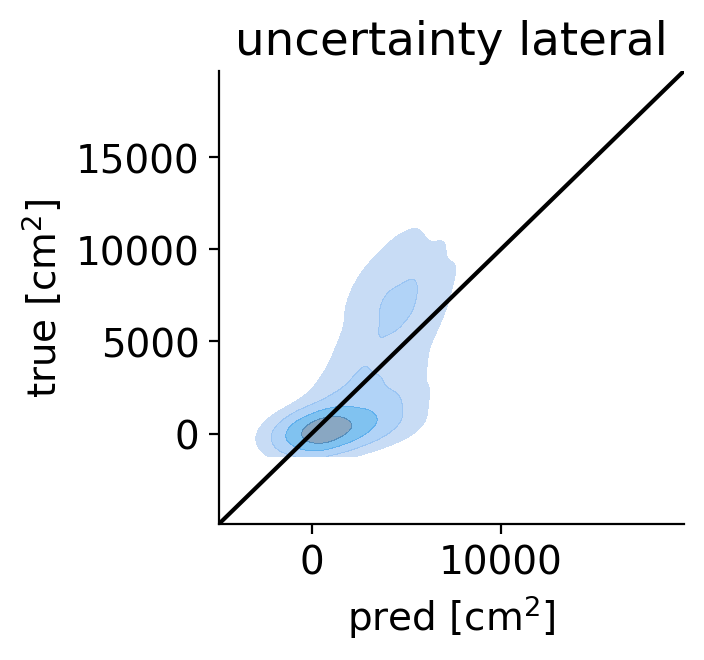

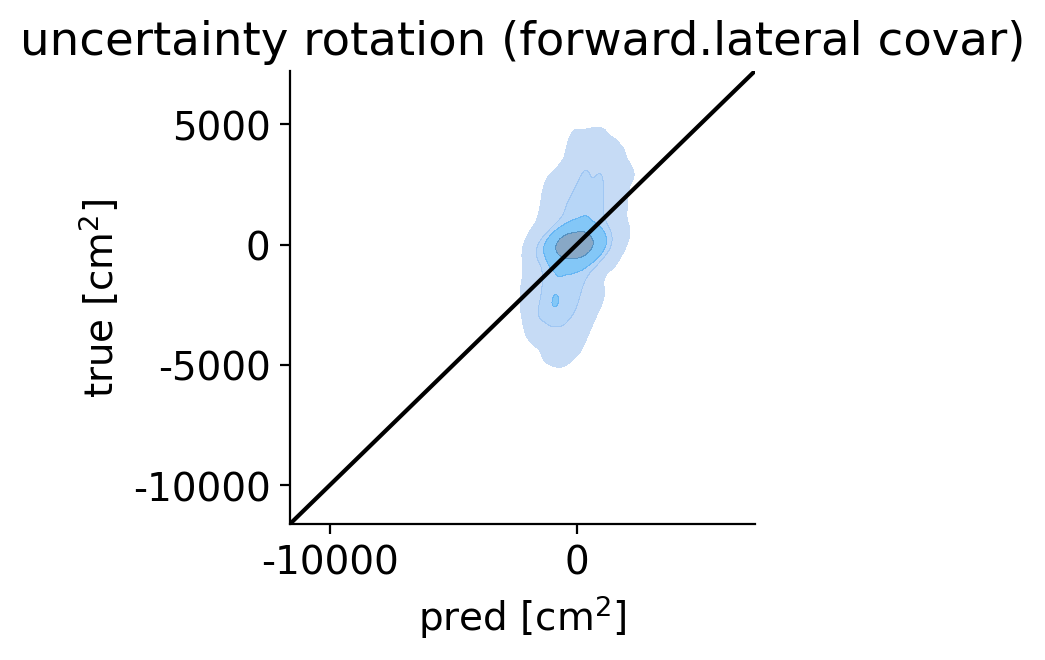

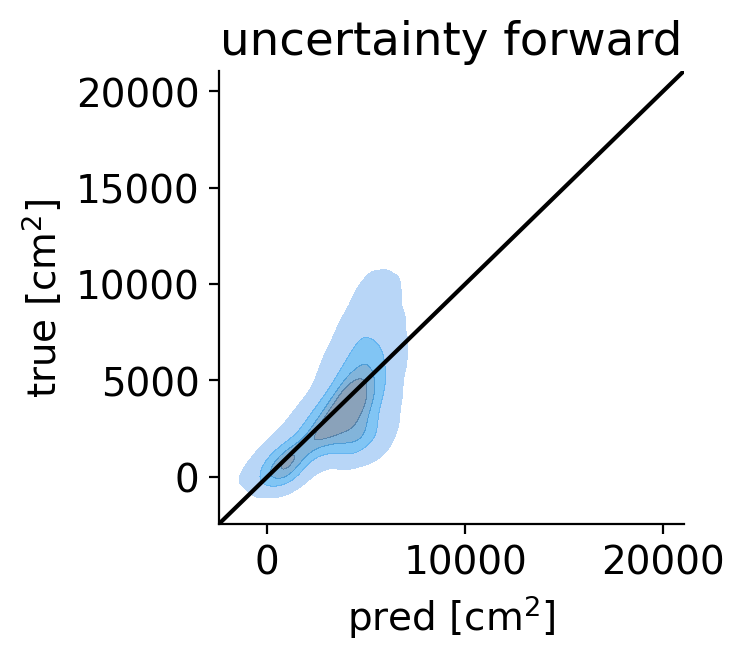

In [32]:
# r --> uncertainty summary statistics in each trial, egocentric
uncertainty=[c[:2,:2].flatten()[[0,1,3]] for c in relativeposcov]
uncertainty=np.array(uncertainty)
trainx, trainy, testx, testy,mask=splitdataxy(modelX, uncertainty)

linreg = linear_model.LinearRegression()
linreg.fit(trainx, trainy)
print('linear regression score',linreg.score(testx, testy))
pred  = linreg.predict(testx)
plot_pred(pred[:,0],testy[:,0], title='uncertainty lateral', unit=r'$cm^2$',every=1)
# plt.scatter(pred[:,0],testy[:,0], s=1, alpha=0.5)
# plt.show()
plot_pred(pred[:,1],testy[:,1], title='uncertainty rotation (forward.lateral covar)', unit=r'$cm^2$',every=1)
plot_pred(pred[:,2],testy[:,2], title='uncertainty forward', unit=r'$cm^2$',every=1)


use neural activity to predict uncertainty var, without covar

linear regression score 0.47934881212930835


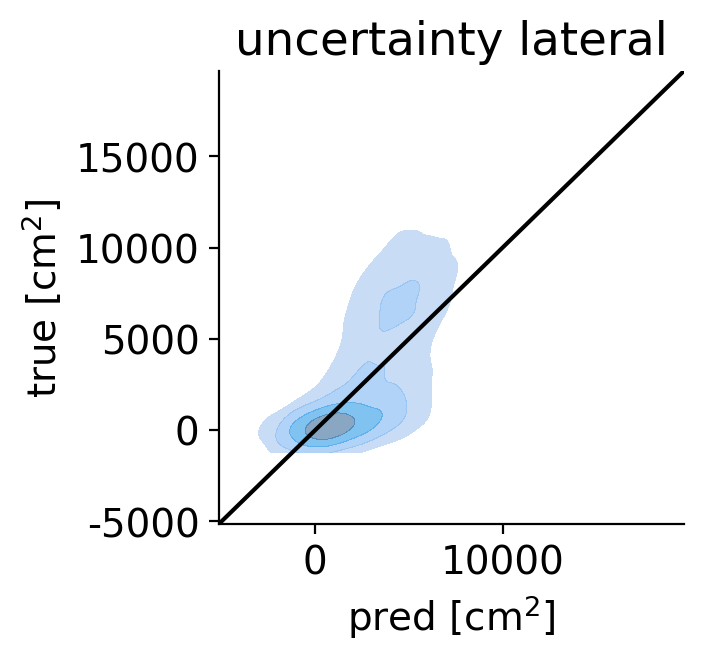

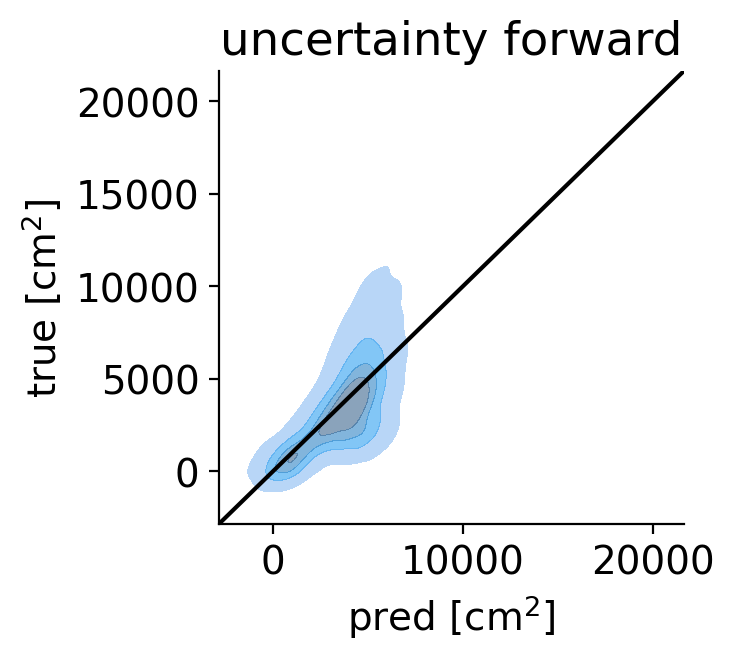

In [37]:
# r --> uncertainty summary statistics in each trial, egocentric
uncertainty=[c[:2,:2].flatten()[[0,3]] for c in relativeposcov]
uncertainty=np.array(uncertainty)
trainx, trainy, testx, testy,mask=splitdataxy(modelX, uncertainty)

linreg = linear_model.LinearRegression()
linreg.fit(trainx, trainy)
print('linear regression score',linreg.score(testx, testy))
pred  = linreg.predict(testx)
plot_pred(pred[:,0],testy[:,0], title='uncertainty lateral', unit=r'$cm^2$',every=1)
plot_pred(pred[:,1],testy[:,1], title='uncertainty forward', unit=r'$cm^2$',every=1)


use neural activity to predict uncertainty std

linear regression score 0.5848447695371294


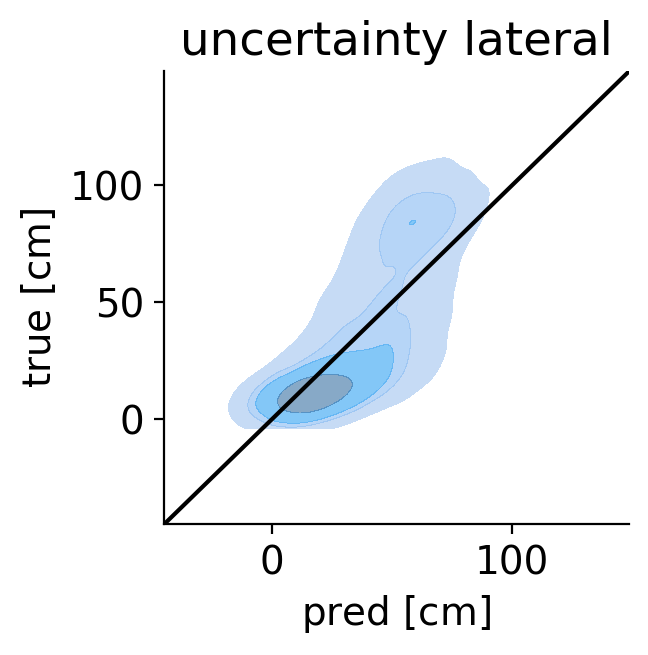

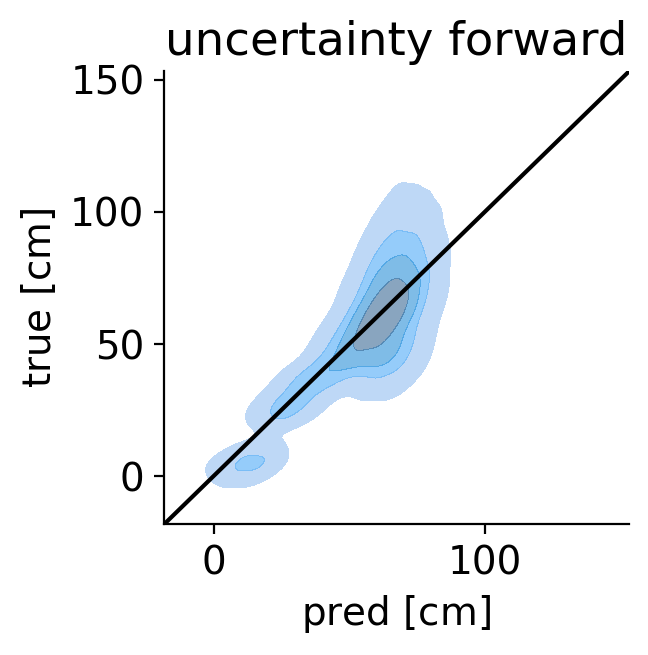

In [34]:
# r --> uncertainty summary statistics in each trial, egocentric
uncertainty=[c[:2,:2].flatten()[[0,3]] for c in relativeposcov]
uncertainty=np.array(uncertainty)
uncertaintyroot=np.power(uncertainty, 0.5)[:,[0,1]]
# neuralpowered=np.power(modelX,2)
trainx, trainy, testx, testy,mask=splitdataxy(modelX,uncertaintyroot)

linreg = linear_model.LinearRegression()
linreg.fit(trainx, trainy)
print('linear regression score',linreg.score(testx, testy))
pred  = linreg.predict(testx)
plot_pred(pred[:,0],testy[:,0], title='uncertainty lateral', unit=r'$cm$',every=1)
plot_pred(pred[:,1],testy[:,1], title='uncertainty forward', unit=r'$cm$',every=1)


## Compare the fitting of var vs std

from the plot, we think the neural activity fit to std better than var.
by stats, the two are similar.
the noise are bit high for us to tell them apart.

In [101]:
# data

uncertainty_var=[c[:2,:2].flatten()[[0,3]] for c in relativeposcov]
uncertainty_var=np.array(uncertainty_var)
uncertainty_std=np.power(uncertainty_var, 0.5)[:,]


together=np.hstack([uncertainty_var,uncertainty_std])
together_normalized=(together-np.quantile(together, 0.05, axis=0))/(np.quantile(together, 0.95, axis=0)-np.quantile(together, 0.05, axis=0))*100

x,y=modelX,together_normalized

In [102]:
# select features to use

from sklearn.model_selection import GridSearchCV

# Create a parameter grid with alpha values
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}

# Initialize the Lasso model
model = linear_model.Lasso()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(x, y)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

print("Best alpha value:", best_alpha)



KeyboardInterrupt: 

In [103]:
model = linear_model.Lasso(alpha=best_alpha)
model.fit(x,y)
model.coef_

array([[ 0.96565189,  0.73550176,  0.55250762, ..., -0.02202916,
        -1.08009933, -0.83121848],
       [-0.22906277, -0.12214355,  0.        , ...,  0.12161036,
         0.59003798,  0.53544026],
       [ 0.89144667,  0.71115817,  0.37584632, ..., -0.60337051,
        -1.14642413, -0.95403825],
       [-0.15745406, -0.22785858,  0.20411665, ...,  0.39782624,
         0.55230545,  0.77755963]])

In [ ]:
# weights of each y dimension.
np.sum(np.abs(model.coef_), axis=1)

array([307.84102567, 204.47151399, 321.81543139, 176.16452222])

In [114]:
# plt.plot(np.cumsum(sorted(abs(np.sum(model.coef_, axis=0)))[::-1]))
# plt.xlabel('number of feature')
# plt.ylabel('var explained')

selectedfeature=np.argsort(abs(np.sum(model.coef_, axis=0)))[::-1][:200]
x=modelX[:,selectedfeature]


In [117]:

model = linear_model.RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5)  # 5-fold cross-validation
# Using cross_val_predict to make predictions
pred = cross_val_predict(model, x, y, cv=5)  # 5-fold cross-validation
# Calculate Mean Squared Error (MSE) using cross_val_score
mse_scores = -cross_val_score(model, x, y, cv=5, scoring='neg_mean_squared_error')
mean_mse = mse_scores.mean(axis=0)

print(f"Mean Squared Error (MSE): {mean_mse}")


Mean Squared Error (MSE): 684.1111532780133


In [122]:
from scipy.stats import pearsonr

for i in range(pred.shape[1]):
    print(pearsonr(pred[:,i],y[:,i]))

(0.5823894737942994, 0.0)
(0.5666901949294729, 0.0)
(0.6508901491422877, 0.0)
(0.6952406019177197, 0.0)


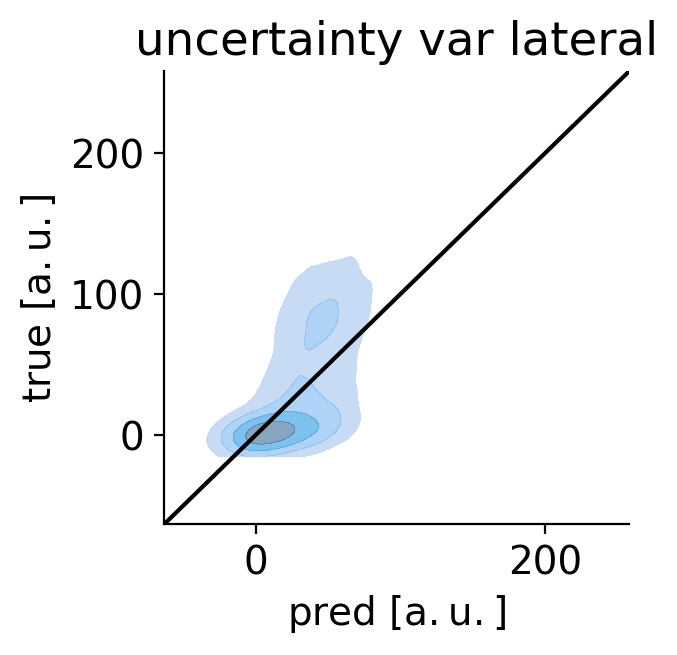

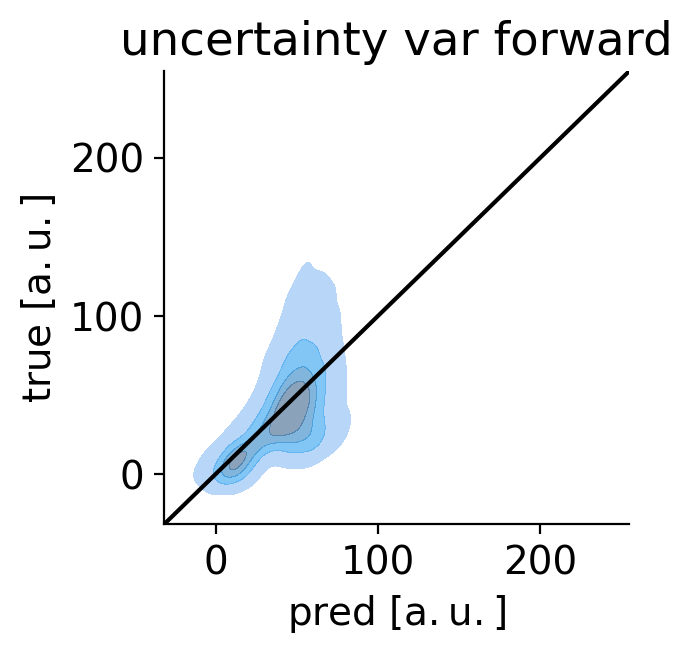

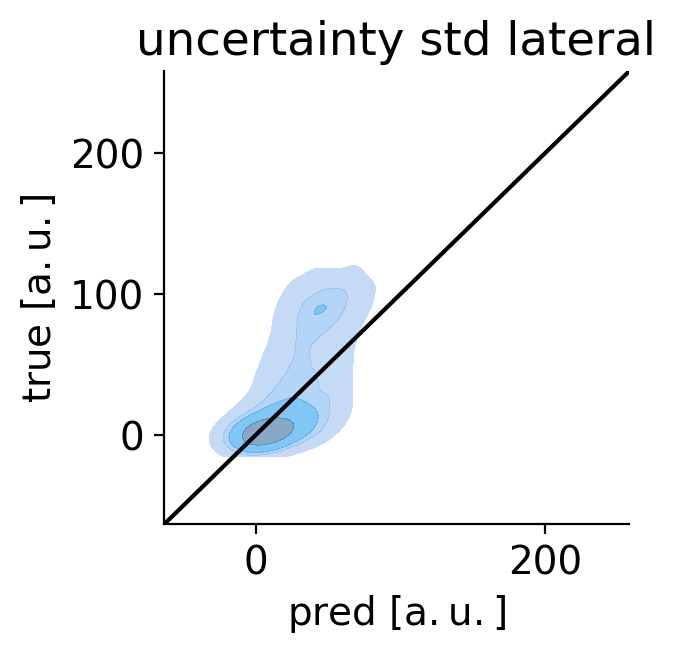

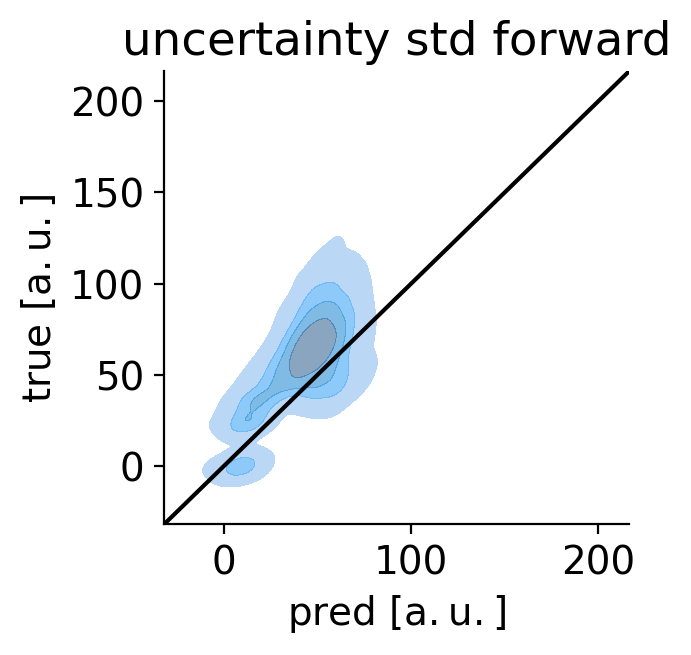

In [123]:

plot_pred(pred[:,0],y[:,0], title='uncertainty var lateral', unit=r'$a.u.$',every=1)
plot_pred(pred[:,1],y[:,1], title='uncertainty var forward', unit=r'$a.u.$',every=1)
plot_pred(pred[:,0],y[:,2], title='uncertainty std lateral', unit=r'$a.u.$',every=1)
plot_pred(pred[:,1],y[:,3], title='uncertainty std forward', unit=r'$a.u.$',every=1) 

## Fit to everything

In [131]:
# data

uncertainty_var=[c[:2,:2].flatten()[[0,3]] for c in relativeposcov]
uncertainty_var=np.array(uncertainty_var)
uncertainty_std=np.power(uncertainty_var, 0.5)[:,]

trialtime=[]
fulltime=np.arange(0,7,0.1)
for itrial in range(len(trials)):
    thistime=len(X['x_monk'][trial_idx==trials[itrial]])
    trialtime.append(fulltime[:thistime])
trialtime=np.hstack(trialtime).T

states_rel, belief_rel = [], []
for itrial in range(len(trials)):
    xr, yr = world2mk(X['x_monk'][trial_idx == trials[itrial]], X['y_monk'][trial_idx == trials[itrial]], X['ang_vel'][trial_idx ==
                      trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    states_rel.append(np.vstack([xr, yr]))

    xr, yr = world2mk(beliefs[trial_idx == trials[itrial]][:, 0], beliefs[trial_idx == trials[itrial]][:, 1], X['ang_vel']
                      [trial_idx == trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    belief_rel.append(np.vstack([xr, yr]))

states_rel = np.hstack(states_rel).T
belief_rel = np.hstack(belief_rel).T


together=np.hstack([uncertainty_var,uncertainty_std,trialtime.reshape(-1,1),(trialtime**2).reshape(-1,1),belief_rel])
together_normalized=(together-np.quantile(together, 0.05, axis=0))/(np.quantile(together, 0.95, axis=0)-np.quantile(together, 0.05, axis=0))*100

x,y=modelX,together_normalized

In [132]:
# select features to use

from sklearn.model_selection import GridSearchCV

# Create a parameter grid with alpha values
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}

# Initialize the Lasso model
model = linear_model.Lasso()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(x, y)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

print("Best alpha value:", best_alpha)



Best alpha value: 0.1


In [133]:
# fit the lasso again using the best alpha
model = linear_model.Lasso(alpha=best_alpha)
model.fit(x,y)
model.coef_

array([[ 0.99063444,  0.1931061 ,  0.81480719, ..., -1.0457454 ,
        -0.        , -0.88789679],
       [-0.28108984, -0.        , -0.        , ...,  0.24391334,
         0.        ,  0.55292329],
       [ 0.90949468,  0.12098639,  0.6102953 , ..., -1.3430726 ,
        -0.        , -0.67894318],
       ...,
       [ 0.47881419,  0.        ,  0.41621233, ..., -0.        ,
        -0.        , -0.21059781],
       [ 0.33094494,  0.059794  ,  0.6765498 , ..., -0.        ,
        -0.        , -0.        ],
       [-0.86156737, -0.50838101, -0.52590101, ..., -0.        ,
        -0.        , -0.40719231]])

In [134]:
# weights of each y dimension.
np.sum(np.abs(model.coef_), axis=1)

array([218.63326603, 154.21749437, 222.85637743, 121.90310089,
       187.96744675, 247.70541302, 174.5153039 , 208.09627762])

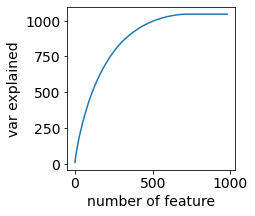

In [135]:
# remove all features that are not important
plt.plot(np.cumsum(sorted(abs(np.sum(model.coef_, axis=0)))[::-1]))
plt.xlabel('number of feature')
plt.ylabel('var explained')

selectedfeature=np.argsort(abs(np.sum(model.coef_, axis=0)))[::-1][:200]
x=modelX[:,selectedfeature]


In [143]:

pred=model.predict(x)

(11331, 200)

In [146]:
# the peason r for each ydim prediction vs true
from scipy.stats import pearsonr
pred = cross_val_predict(model, x, y, cv=5)
for i in range(model.coef_.shape[0]):
    print(pearsonr(pred[:,i],y[:,i]))

(0.6233969816596376, 0.0)
(0.5865697283205911, 0.0)
(0.6841854357926818, 0.0)
(0.7129089699441167, 0.0)
(0.7916823404873763, 0.0)
(0.6596408003683067, 0.0)
(0.5615491889310715, 0.0)
(0.6882687301429711, 0.0)


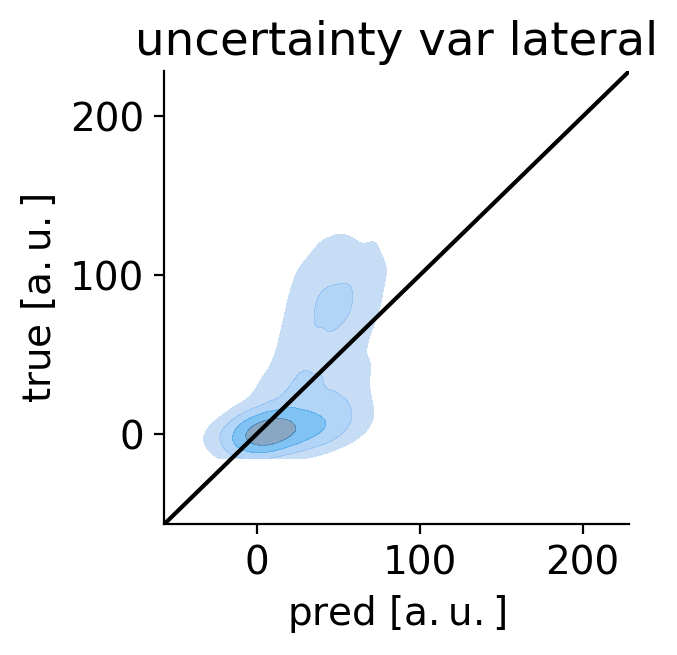

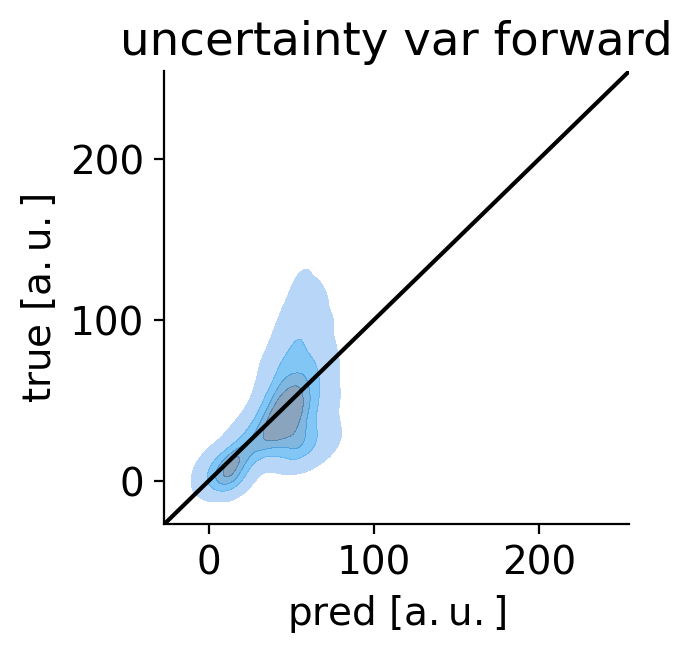

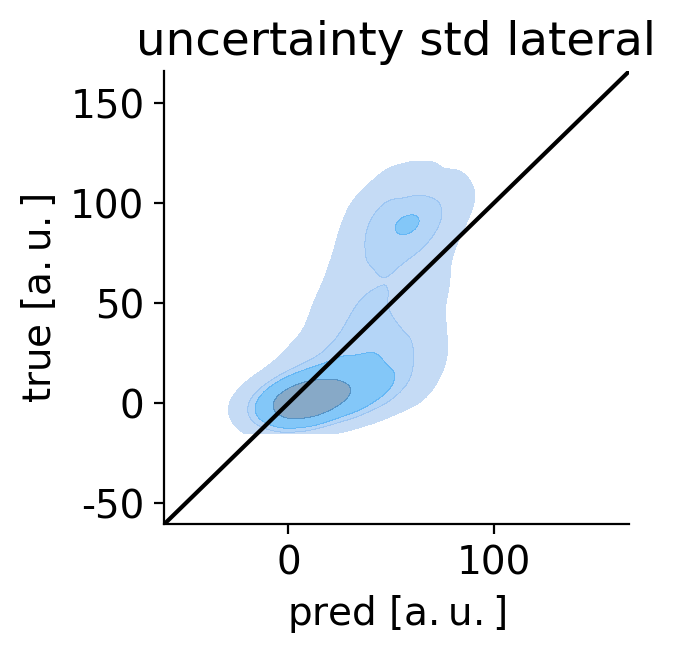

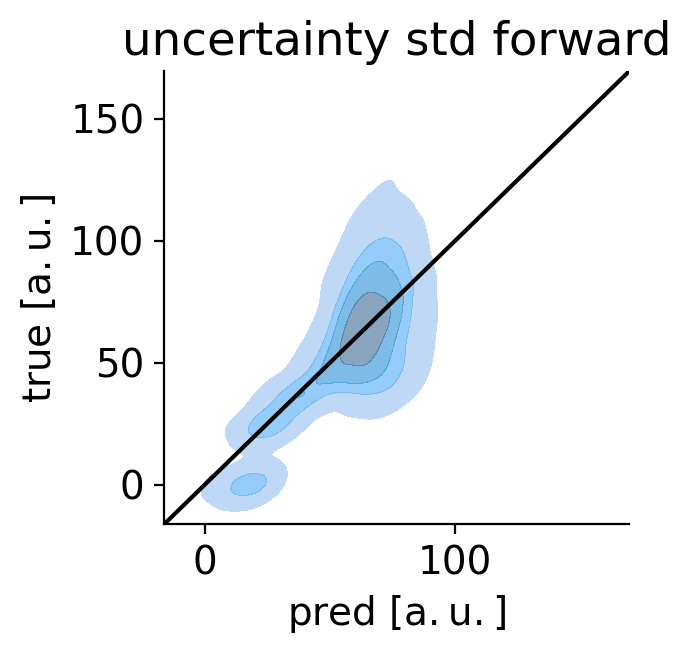

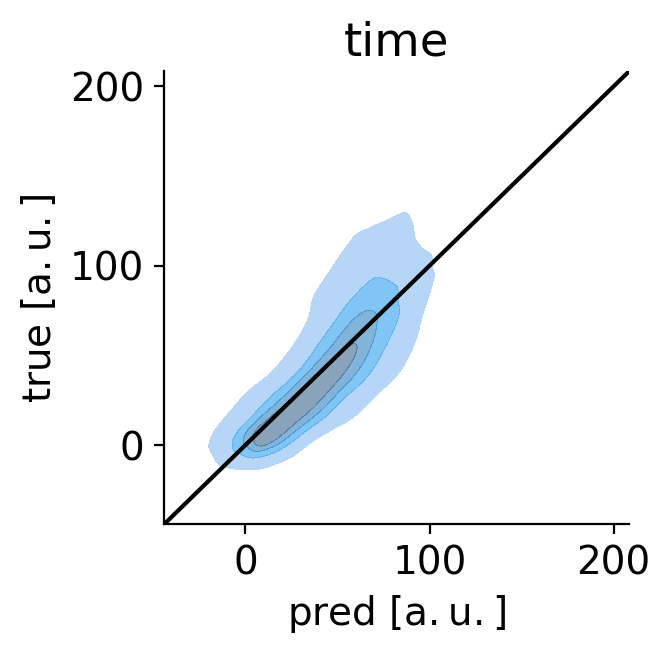

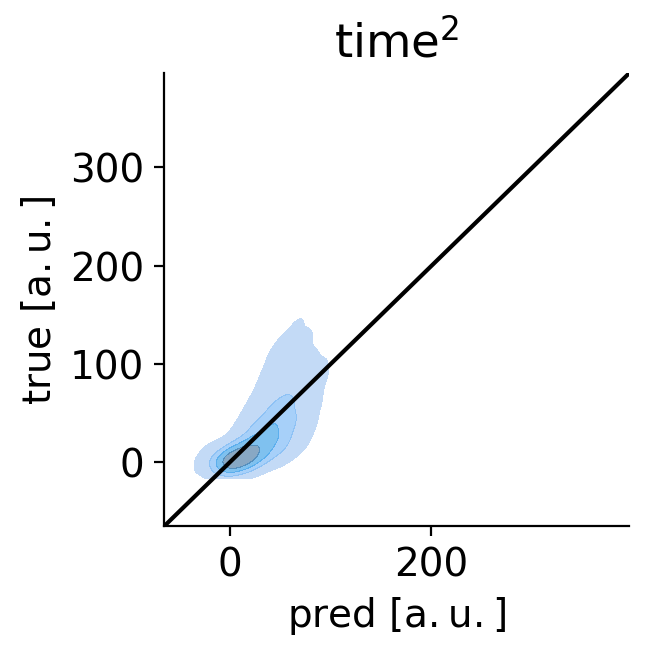

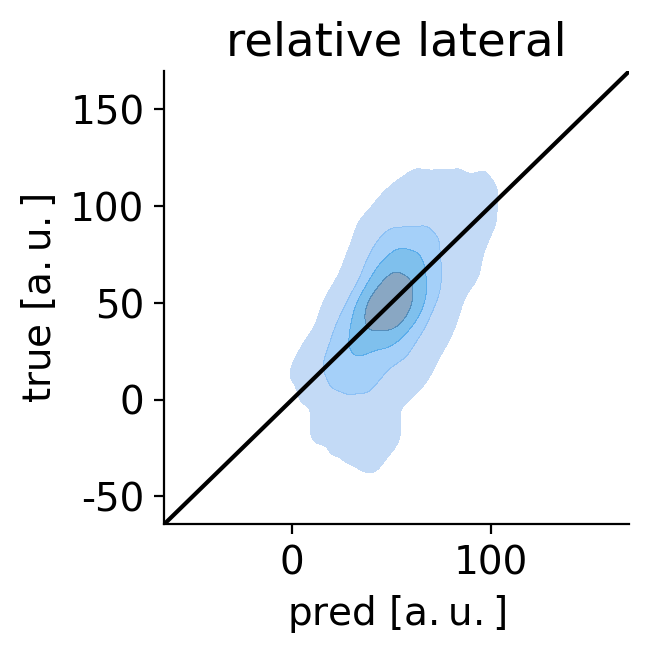

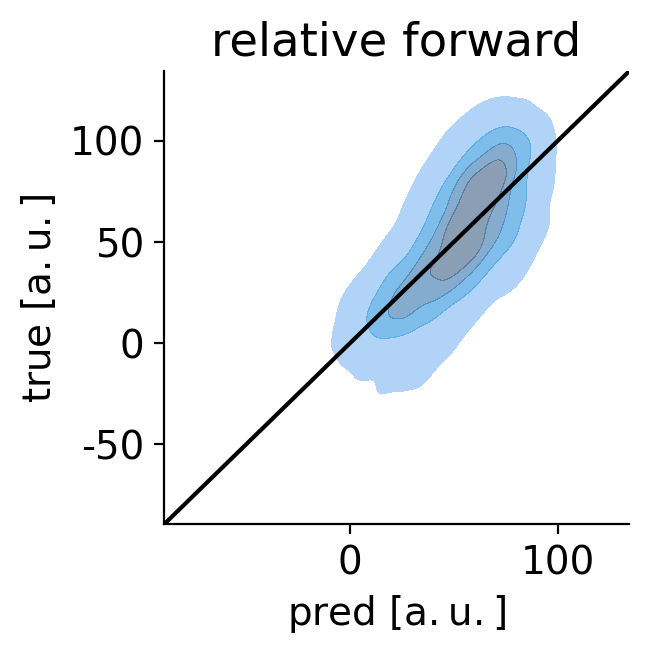

In [148]:
# plot the fit pred vs true

plot_pred(pred[:,0],y[:,0], title='uncertainty var lateral', unit=r'$a.u.$',every=1)
plot_pred(pred[:,1],y[:,1], title='uncertainty var forward', unit=r'$a.u.$',every=1)
plot_pred(pred[:,2],y[:,2], title='uncertainty std lateral', unit=r'$a.u.$',every=1)
plot_pred(pred[:,3],y[:,3], title='uncertainty std forward', unit=r'$a.u.$',every=1) 
plot_pred(pred[:,4],y[:,4], title='time', unit=r'$a.u.$',every=1)
plot_pred(pred[:,5],y[:,5], title=r'$time^2$', unit=r'$a.u.$',every=1)
plot_pred(pred[:,6],y[:,6], title='relative lateral', unit=r'$a.u.$',every=1)
plot_pred(pred[:,7],y[:,7], title='relative forward', unit=r'$a.u.$',every=1) 

# we can predict the uncertainty subspace well.

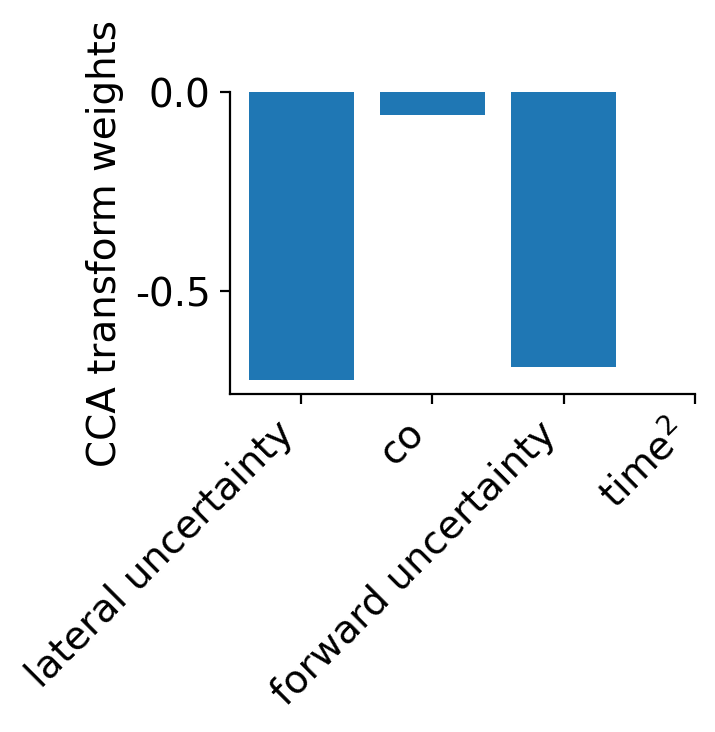

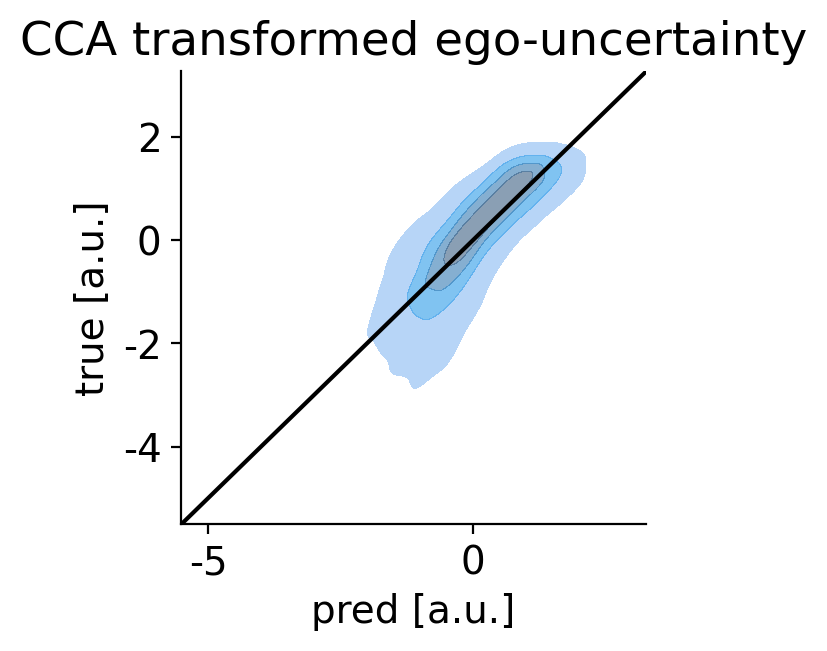

In [ ]:
uncertainty=[c[:2,:2].flatten()[[0,1,3]] for c in relativeposcov]
uncertainty=np.array(uncertainty)
trainx, trainy, testx, testy,mask=splitdataxy(np.power(modelX,2), uncertainty)

cca = CCA(n_components=1)
cca.fit(trainx, trainy)
trainxc, trainyc = cca.transform(trainx, trainy)
testxc, testyc = cca.transform(trainx, trainy)
# plot_pred(trainxc.reshape(-1),trainyc.reshape(-1), title='CCA transformed', unit='cm',every=1)

with initiate_plot(3,2,200) as f:
    ax=f.add_subplot(111)
    plt.bar(list(range(len(cca.y_rotations_))),cca.y_rotations_.reshape(-1))
    quickspine(ax)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['lateral uncertainty', 'co','forward uncertainty',r'$time^2$'], rotation=45, ha='right')
    plt.ylabel('CCA transform weights')
    
linreg = linear_model.LinearRegression()
linreg.fit(trainxc, trainyc)
pred  = linreg.predict(testxc)
plot_pred(pred[:,0],testyc[:,0], title='CCA transformed ego-uncertainty', unit='a.u.',every=1)



## Fitting belief uncertainty summary stats to other aspect of neural data

so far we check the firing rate coding and found that neural firings encode some uncertainty.
however, the neurons might also encode uncertainty in some other ways.
for example, neural firing variance.

In [ ]:

# population variance -> uncertainty summary stats
populationvar=np.var(modelX,axis=1).reshape(-1,1)
trainx, trainy, testx, testy,mask=splitdataxy(populationvar, uncertainty)

linreg = linear_model.LinearRegression()
linreg.fit(trainx, trainy)

pred  = linreg.predict(testx)
# plot_pred(pred[:,0],testy[:,0], title='uncertainty x', unit=r'$cm^2$',every=1)
# plot_pred(pred[:,1],testy[:,1], title='uncertainty xy correlation', unit=r'$cm^2$',every=1)
# plot_pred(pred[:,2],testy[:,2], title='uncertainty y', unit=r'$cm^2$',every=1)